# Challenge: What to use
Using selected questions from the 2012 and 2014 editions of the [European Social Survey](http://www.europeansocialsurvey.org/data/round-index.html), address the following questions. Keep track of your code and results in a Jupyter notebook or other source that you can share with your mentor. For each question, explain why you chose the approach you did.

Here is the [data file](https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/ESS_practice_data/ESSdata_Thinkful.csv). And here is the [codebook](https://thinkful-ed.github.io/data-201-resources/ESS_practice_data/ESS_codebook.html), with information about the variable coding and content.

In this dataset, the same participants answered questions in 2012 and again 2014.

1. Did people become less trusting from 2012 to 2014? Compute results for each country in the sample.
2. Did people become happier from 2012 to 2014? Compute results for each country in the sample.
3. Who reported watching more TV in 2012, men or women?
4. Who was more likely to believe people were fair in 2012, people living with a partner or people living alone?
5. Pick three or four of the countries in the sample and compare how often people met socially in 2014. Are there differences, and if so, which countries stand out?
6. Pick three or four of the countries in the sample and compare how often people took part in social activities, relative to others their age, in 2014. Are there differences, and if so, which countries stand out?

In [253]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro, normaltest, wilcoxon, mannwhitneyu, median_test, kruskal
%matplotlib inline

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/ESS_practice_data/ESSdata_Thinkful.csv')

In [4]:
data.head()

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0


**Quick definitions for reference:**
- cntry: Country
- idno: Respondent's identification number
- year: ESS round (6 is 2012; 7 is 2014)
- tvtot: TV watching, total time on average weekday (1-7: different numbers aren't in hours, they are categories of times, higher is more TV)
- ppltrst: Most people can be trusted (10) or you can't be too careful (0)
- pplfair: Most people try to take advantage of you (0), or try to be fair (10)
- pplhlp: Most of the time people helpful (10) or mostly looking out for themselves (0)
- happy: How happy are you (0-10: extremely unhappy-extremely happy)
- sclmeet: How often socially meet with friends, relatives or colleagues (1-7: different categories a la tvtot, higher number, more social meeting)
- sclact:Take part in social activities compared to others of same age (1-5: much less than most - much more than most)
- gndr: Gender (1 Male; 2 Female)
- agea: Age of respondent, calculated
- partner: Lives with husband/wife/partner at household grid (1 Lives with husband/wife/partner at household grid; 2 Does Not)

*Note: According to the [documentation page](https://thinkful-ed.github.io/data-201-resources/ESS_practice_data/ESS_codebook.html) - "The data file is checked for: duplication of ID numbers, variable names and formats, empty records, wild codes and logical inconsistencies. Missing values have been assigned."* So, initial cleaning and preprocessing has already been done.

## Quick EDA

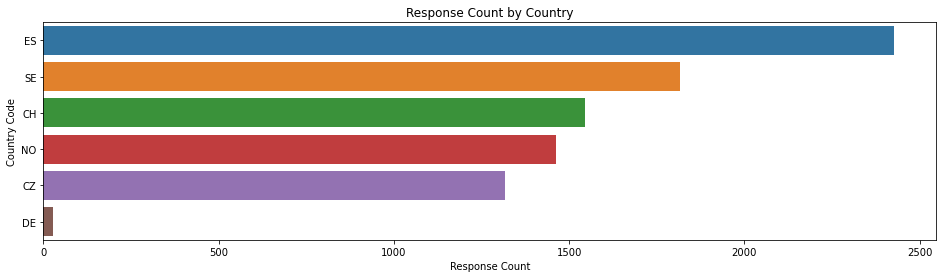

In [16]:
plt.figure(figsize=(16, 4))
sns.barplot(data.cntry.value_counts().values, data.cntry.value_counts().index)
plt.title('Response Count by Country')
plt.xlabel('Response Count')
plt.ylabel('Country Code')
plt.show()

There are six countries that took part in the survey for both periods. Looks like DE (Germany) barely has any respondents (28 total, so I'm assuming 14 people), thus it may be difficult to get accurate results for questions specific to DE (Germany).

In [22]:
len(data.idno.unique()) / data.shape[0]

0.35908773562950896

I would have guessed that the number of unique ID's would be half of the total responses based on the claim made by the documentation (implying that each respondent answered for each year), but that doesn't appear to actually be the case, this means there may be an imbalance between year/country for the responses and also may not be able to use pairwise comparison for many of these.

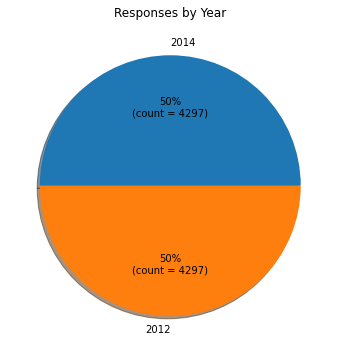

In [38]:
plt.figure(figsize=(6,6))
plt.pie(data.year.value_counts(), labels=['2014', '2012'], autopct=lambda pct: f'{int(pct)}%\n(count = {int(pct/100 * data.shape[0])})', shadow=True)
plt.title('Responses by Year')
plt.show()

The data looks to be evenly split by the year, but what if this is broken down by country?

In [50]:
data.groupby(['cntry', 'year']).agg('count').idno

cntry  year
CH     6        773
       7        773
CZ     6        658
       7        658
DE     6         14
       7         14
ES     6       1213
       7       1213
NO     6        731
       7        731
SE     6        908
       7        908
Name: idno, dtype: int64

Alright, pretty easy to see that the number of respondents for each year is also identical for each country, which is good! But the unique IDs count indicated that the respondents are likely not identical in each year. Perhaps the ID numbers are only unique to their actual country (i.e. for CH the first respondent is 1, next is 2, but that is the same for any other country - meaning the IDs are only unique in the context of the country, and not in the dataset as a whole). This is essential to know!

In [73]:
data.isna().sum()

cntry        0
idno         0
year         0
tvtot        8
ppltrst     14
pplfair     39
pplhlp      25
happy       31
sclmeet     15
sclact      94
gndr        10
agea       239
partner     17
dtype: int64

Looks like some null values actually got missed in the preprocessing. But are they actually null?

In [76]:
data[data.isnull().any(axis=1)]

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
5,CH,36.0,6,4.0,6.0,7.0,3.0,8.0,7.0,4.0,2.0,NaN,2.0
41,CH,193.0,6,5.0,3.0,5.0,5.0,8.0,3.0,4.0,2.0,NaN,1.0
122,CH,568.0,6,5.0,9.0,9.0,10.0,10.0,4.0,NaN,2.0,39.0,1.0
158,CH,686.0,6,2.0,3.0,10.0,5.0,10.0,7.0,NaN,2.0,NaN,1.0
174,CH,715.0,6,2.0,8.0,8.0,5.0,NaN,6.0,4.0,1.0,70.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8192,SE,1827.0,7,1.0,9.0,9.0,9.0,10.0,7.0,NaN,2.0,48.0,1.0
8339,SE,2587.0,7,6.0,7.0,6.0,7.0,10.0,7.0,NaN,1.0,35.0,1.0
8384,SE,2836.0,7,NaN,4.0,6.0,8.0,8.0,7.0,1.0,2.0,31.0,2.0
8393,SE,2875.0,7,0.0,8.0,10.0,10.0,10.0,7.0,NaN,1.0,30.0,2.0


Looks to be so, the best way to deal with this since most of the questions are variable specific, is remove relevant nulls for each specific variable when questions about that variable appear. Since each response in each year is ID paired, it's probably best to remove a relevant variable null respondent by ID from both years/surveys if either one contains a null (because then they can't accurately be compared survey to survey in the case of nulls).

In [59]:
for country in data.cntry.unique():
    ids_6 = set(data[(data.cntry == country) & (data.year == 6)].idno)
    ids_7 = set(data[(data.cntry == country) & (data.year == 7)].idno)
    if ids_6 == ids_7:
        print(country, True)
    else:
        print(country, False)

CH True
CZ True
DE True
ES True
NO True
SE True


Looks like this is actually true for each country, this is good to know since we can use pairwise tests for each of these since the same people are actually answering in each year. Just keep in mind that IDs are only unique within their particular country.

In [79]:
data.groupby(['cntry', 'year']).agg(['mean', 'median', 'std', 'count']).iloc[:, 4:]

tvtot                          ppltrst                         \
                mean median       std count      mean median       std count   
cntry year                                                                     
CH    6     3.141192    3.0  1.913706   772  5.677878    6.0  2.130701   773   
      7     3.065977    3.0  1.922607   773  5.751617    6.0  2.143888   773   
CZ    6     5.142420    6.0  1.851775   653  4.362519    4.0  2.409738   651   
      7     4.686930    5.0  2.039006   658  4.424658    5.0  2.305389   657   
DE    6     4.928571    5.5  2.129077    14  5.214286    5.0  1.528125    14   
      7     3.071429    3.0  2.092635    14  5.357143    5.5  2.530039    14   
ES    6     3.977741    4.0  2.062233  1213  5.114592    5.0  2.183623  1213   
      7     4.015677    4.0  2.021091  1212  4.895128    5.0  2.148165  1211   
NO    6     3.837209    4.0  1.900118   731  6.649315    7.0  1.749868   730   
      7     3.705882    4.0  1.910951   731  6.598630    7.0  1.811183   730   
SE    6     3.691630    4.0  1.825839   908  6.058499    7.0  2.055554   906   
      7     3.585447    4.0  1.891111   907  6.257709    7.0  2.005422   908   

             pplfair         ...      gndr             agea                    \
                mean median  ...       std count       mean median        std   
cntry year                   ...                                                
CH    6     6.350649    7.0  ...  0.500102   773  47.344415   47.0  18.506694   
      7     6.219922    7.0  ...  0.500173   773  46.141145   45.0  18.750966   
CZ    6     4.959938    5.0  ...  0.500149   658  47.053208   47.0  17.430839   
      7     4.904255    5.0  ...  0.499124   648  45.552262   45.0  16.310105   
DE    6     5.692308    6.0  ...  0.513553    14  52.071429   54.0  16.578319   
      7     6.714286    7.0  ...  0.513553    14  59.714286   56.5  15.162852   
ES    6     5.354253    5.0  ...  0.499973  1213  47.700340   46.0  17.788028   
      7     5.340284    5.0  ...  0.500168  1213  48.048223   47.0  18.608818   
NO    6     6.927298    7.0  ...  0.499555   731  46.364903   46.0  17.883257   
      7     6.861454    7.0  ...  0.498819   731  46.707521   47.0  18.529955   
SE    6     6.559116    7.0  ...  0.499455   908  48.673563   50.0  19.241285   
      7     6.836464    7.0  ...  0.499965   908  49.403189   51.0  19.829526   

                   partner                         
           count      mean median       std count  
cntry year                                         
CH    6      752  1.349288    1.0  0.477054   773  
      7      751  1.376455    1.0  0.484810   773  
CZ    6      639  1.432927    1.0  0.495859   656  
      7      641  1.420245    1.0  0.493977   652  
DE    6       14  1.357143    1.0  0.497245    14  
      7       14  1.142857    1.0  0.363137    14  
ES    6     1178  1.372727    1.0  0.483730  1210  
      7     1182  1.398347    1.0  0.489760  1210  
NO    6      718  1.348422    1.0  0.476798   729  
      7      718  1.390411    1.0  0.488177   730  
SE    6      870  1.387665    1.0  0.487486   908  
      7      878  1.386564    1.0  0.487231   908  

[12 rows x 40 columns]

Can already see there may be some differences from survey to survey for a lot of these responses within the countries - some being more drastic than others. (Don't forget DE only has 14 responses for each year! The others countries each have 600+ per year.) I think that's a pretty good idea of the data at a glance, so time to start answering questions.

## 1. Did people become less trusting from 2012 to 2014? Compute results for each country in the sample.

This question is specifically asking about individual countries and the changes from survey 6 (2012) to 7 (2014) regarding the variable `ppltrst`: Most people can be trusted (10) or you can't be too careful (0). This variable is essentially a rank/ordinal variable. There isn't a defined distance between 0 to 10, but we do know that 1 is more trustful than 0 and 2 is more trustful of 1 and so on. Therefore the responses are highly subjective depending on how you think of the question. (What actually constitutes a score of 5 or 6 or any of the numbers really out in the real world? This is especially hard to surmise and is definitely a generalization. Also could think a the same level of trustworthiness can fall under different labels/ranks?) With that said, a general idea can still be of use, especially if results are glaringly different from survey to survey.

In [84]:
data.groupby(['cntry', 'year']).agg(['mean', 'median', 'std', 'count']).iloc[:, 2:].ppltrst

mean  median       std  count
cntry year                                   
CH    6     5.677878     6.0  2.130701    773
      7     5.751617     6.0  2.143888    773
CZ    6     4.362519     4.0  2.409738    651
      7     4.424658     5.0  2.305389    657
DE    6     5.214286     5.0  1.528125     14
      7     5.357143     5.5  2.530039     14
ES    6     5.114592     5.0  2.183623   1213
      7     4.895128     5.0  2.148165   1211
NO    6     6.649315     7.0  1.749868    730
      7     6.598630     7.0  1.811183    730
SE    6     6.058499     7.0  2.055554    906
      7     6.257709     7.0  2.005422    908

Here's a good breakdown of a few measures of central tendency as well as the standard deviations from the mean (also the count for each country/year pair - notice they aren't always equal, any respondents with null results will be removed).

In [109]:
def make_country_year_dfs_by_var(df, variable):
    dfs = {}
    for country in data.cntry.unique():
        country_df = df[df.cntry == country].copy()
        #get IDs that have a null result for either survey regarding the variable of interest
        bad_ids = country_df[country_df[variable].isna()].idno.values
        #filter out bad IDs
        country_df = country_df[country_df.idno.apply(lambda x: x not in bad_ids)]
        for year in [6, 7]:
            dfs[country, year] = country_df[country_df.year == year].copy()
    return dfs

In [110]:
trst_dfs = make_country_year_dfs_by_var(data, 'ppltrst')

In [126]:
def make_sns_distplots(dfs_dict, variable):

        sns.distplot(dfs_dict[key][variable])
        plt.title(f'{key[0]}-{key[1]} {variable} Distplot')
    plt.show()

In [157]:
def make_qq_plots(dfs_dict, variable):
    plt.figure(figsize=(16,30))
    for i, key in enumerate(dfs_dict, 1):
        ax = plt.subplot(6, 2, i)
        fig = qqplot(dfs_dict[key][variable], line='s', ax=ax)
        plt.title(f'{key[0]}-{key[1]} {variable} QQ-Plot')
    plt.show()

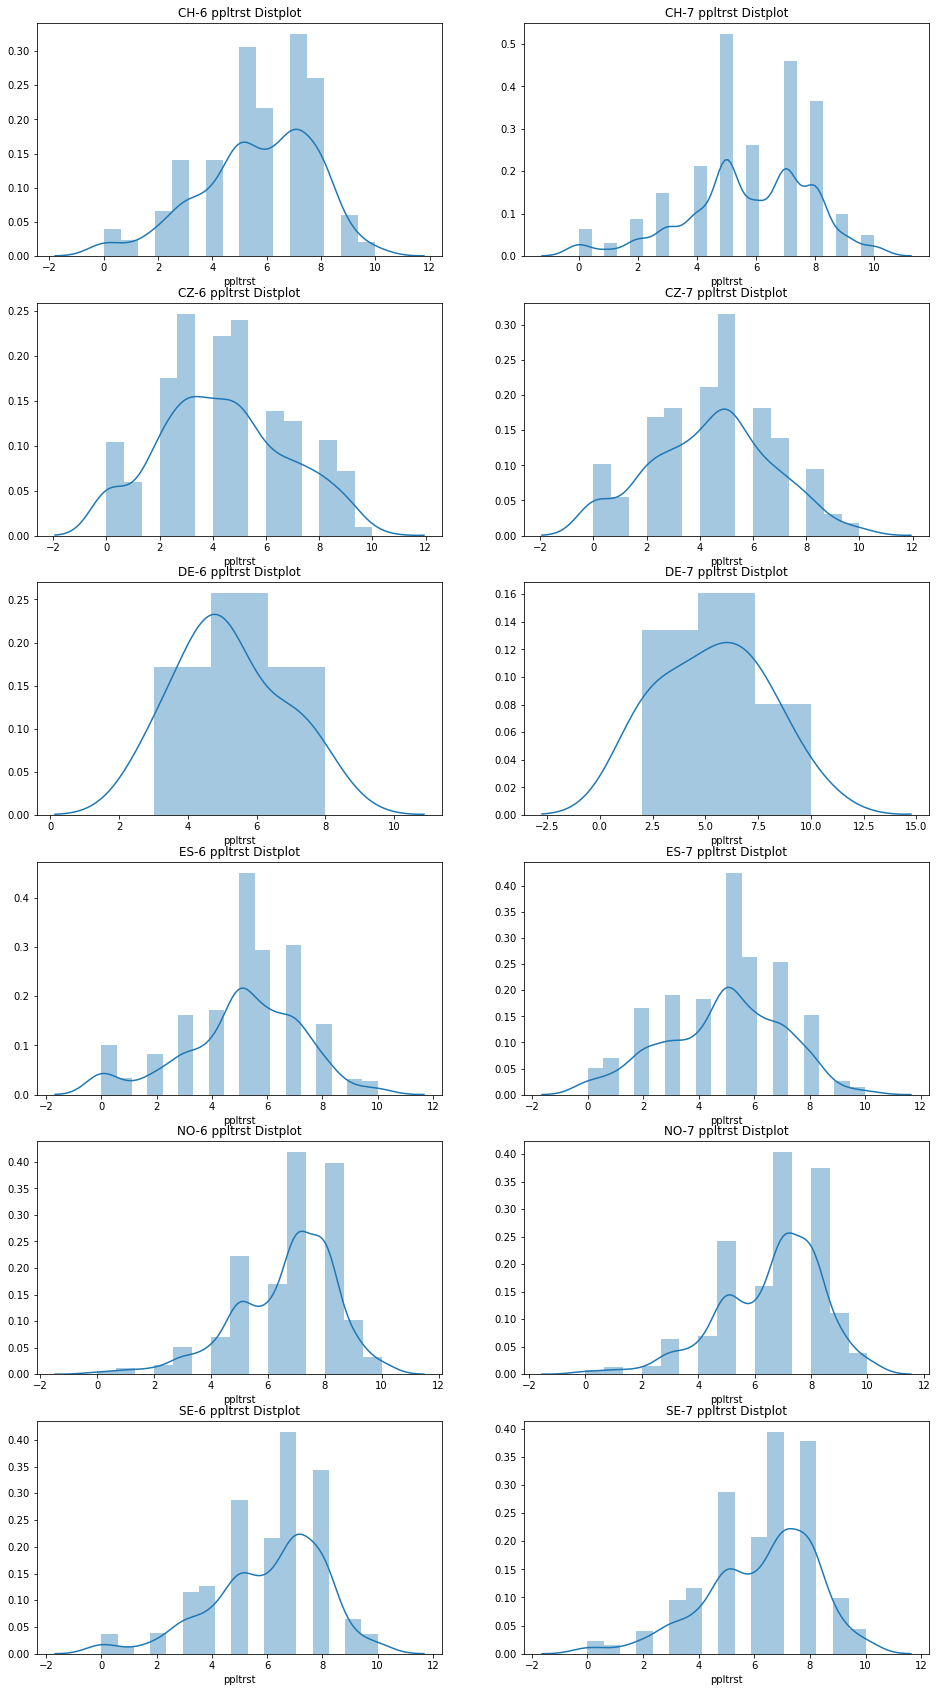

In [128]:
make_sns_distplots(trst_dfs, 'ppltrst')

From the above, it isn't too hard to see that most of the response distributions generally follow an approximately normal distribution, however, it is easy to see that this is a categorical response (as are all of these responses really), so the question is, what test is appropriate to tell if there is a significant difference in each country from year to year with this information in mind? Should a non-parametric or parametric test be used? Let's dig a little deeper into the normality of each of these distributions.

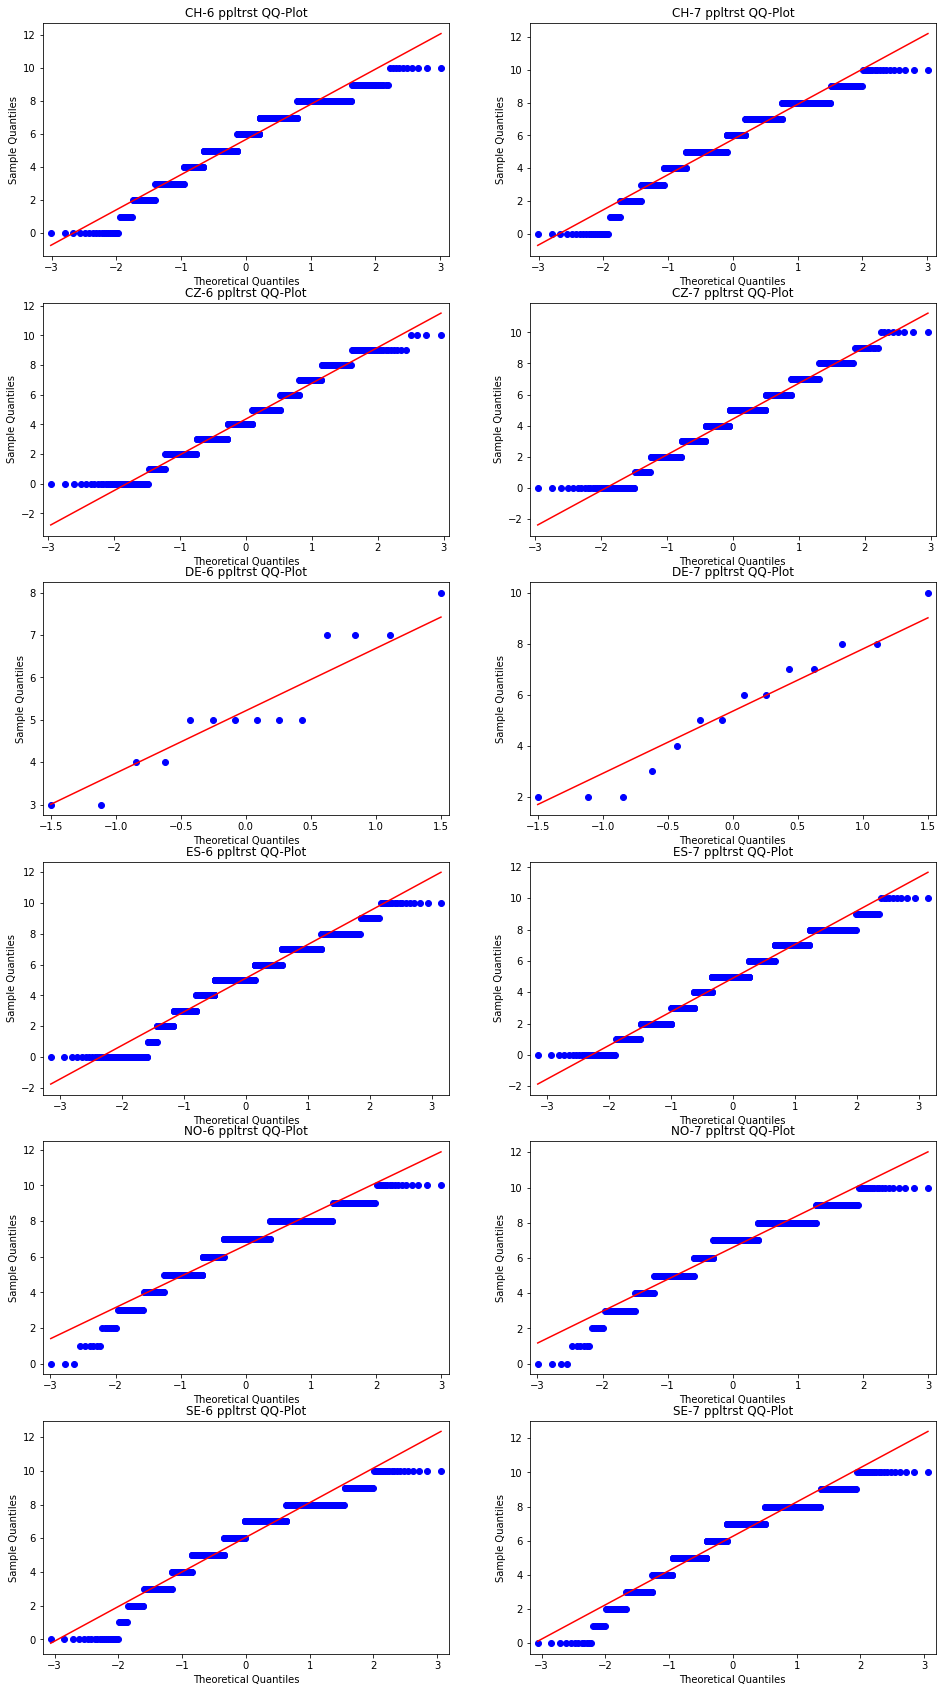

In [158]:
make_qq_plots(trst_dfs, 'ppltrst')

Looking at the QQ plots, the categorical-ness of this data is even more apparent. For the most part, it isn't easy to say these follow a normal distribution, but it wouldn't be crazy if they were considered to be one.

In [163]:
def statistical_norm_tests(data_dict, variable):
    for key in data_dict:
        shap_res = shapiro(data_dict[key][variable])
        norm_res = normaltest(data_dict[key][variable])
        print(f'{key} {variable}:')
        print(f'Shapiro-Wilk: {shap_res}')
        print(f'{norm_res}')

In [164]:
statistical_norm_tests(trst_dfs, 'ppltrst')

('CH', 6) ppltrst:
Shapiro-Wilk: (0.9519361853599548, 3.4958809444132896e-15)
NormaltestResult(statistic=34.41403485540727, pvalue=3.365792056559453e-08)
('CH', 7) ppltrst:
Shapiro-Wilk: (0.9538647532463074, 7.692136586977955e-15)
NormaltestResult(statistic=32.07122389622901, pvalue=1.0859809748932778e-07)
('CZ', 6) ppltrst:
Shapiro-Wilk: (0.9674475193023682, 7.925918255047293e-11)
NormaltestResult(statistic=25.37334460803209, pvalue=3.0920622216317257e-06)
('CZ', 7) ppltrst:
Shapiro-Wilk: (0.9716485738754272, 6.767588156542104e-10)
NormaltestResult(statistic=8.566961284450933, pvalue=0.013794564486135795)
('DE', 6) ppltrst:
Shapiro-Wilk: (0.9013110399246216, 0.1178363636136055)
NormaltestResult(statistic=0.5537028123495471, pvalue=0.7581671476973477)
('DE', 7) ppltrst:
Shapiro-Wilk: (0.9425466060638428, 0.4519253373146057)
NormaltestResult(statistic=0.6451892229565249, pvalue=0.7242674045554323)
('ES', 6) ppltrst:
Shapiro-Wilk: (0.9498075246810913, 6.682197632750638e-20)
NormaltestRes

All these basically say that the data doesn't follow a normal distribution, the only ones where it doesn't indicate that is for DE (Germany) which we know is an extremely small sample, so the tests don't really have enough information to be sure. This makes me conclude that non-parametric tests are probably better to use here. In particular, since we have the same respondents just in different years, the Wilcoxon signed-rank test should tell us if there is a significant difference between the results over the years for each country.

In [178]:
for country in data.cntry.unique():
    x = trst_dfs[country, 7].sort_values('idno').ppltrst
    y = trst_dfs[country, 6].sort_values('idno').ppltrst
    print(country, wilcoxon(x, y, alternative='less'))

CH WilcoxonResult(statistic=113837.5, pvalue=0.7794356744523762)
CZ WilcoxonResult(statistic=86816.0, pvalue=0.6887881612324424)
DE WilcoxonResult(statistic=47.0, pvalue=0.5421432699550068)
ES WilcoxonResult(statistic=243475.5, pvalue=0.0037715740382147905)
NO WilcoxonResult(statistic=85392.0, pvalue=0.3583530255723916)
SE WilcoxonResult(statistic=155426.5, pvalue=0.9808440819605301)


So, based on the above, the only country that indicates a statistically significant fall in trust is ES (Spain). 

In [184]:
for country in data.cntry.unique():
    x = trst_dfs[country, 7].sort_values('idno').ppltrst
    y = trst_dfs[country, 6].sort_values('idno').ppltrst
    print(country, wilcoxon(x, y, alternative='greater'))

CH WilcoxonResult(statistic=113837.5, pvalue=0.22056432554762384)
CZ WilcoxonResult(statistic=86816.0, pvalue=0.31121183876755765)
DE WilcoxonResult(statistic=47.0, pvalue=0.45785673004499317)
ES WilcoxonResult(statistic=243475.5, pvalue=0.9962284259617852)
NO WilcoxonResult(statistic=85392.0, pvalue=0.6416469744276083)
SE WilcoxonResult(statistic=155426.5, pvalue=0.019155918039469925)


And on the other side of the coin, the only country where it looks like there was a significant rise in trustworthiness from 2012 to 2014 was SE. The rest don't appear to be significantly different from one another.

## 2. Did people become happier from 2012 to 2014? Compute results for each country in the sample.

Same process here, just in a different context (happiness).

In [186]:
happy_dfs = make_country_year_dfs_by_var(data, 'happy')

Check normality, I'm going to guess things will be pretty similar here.

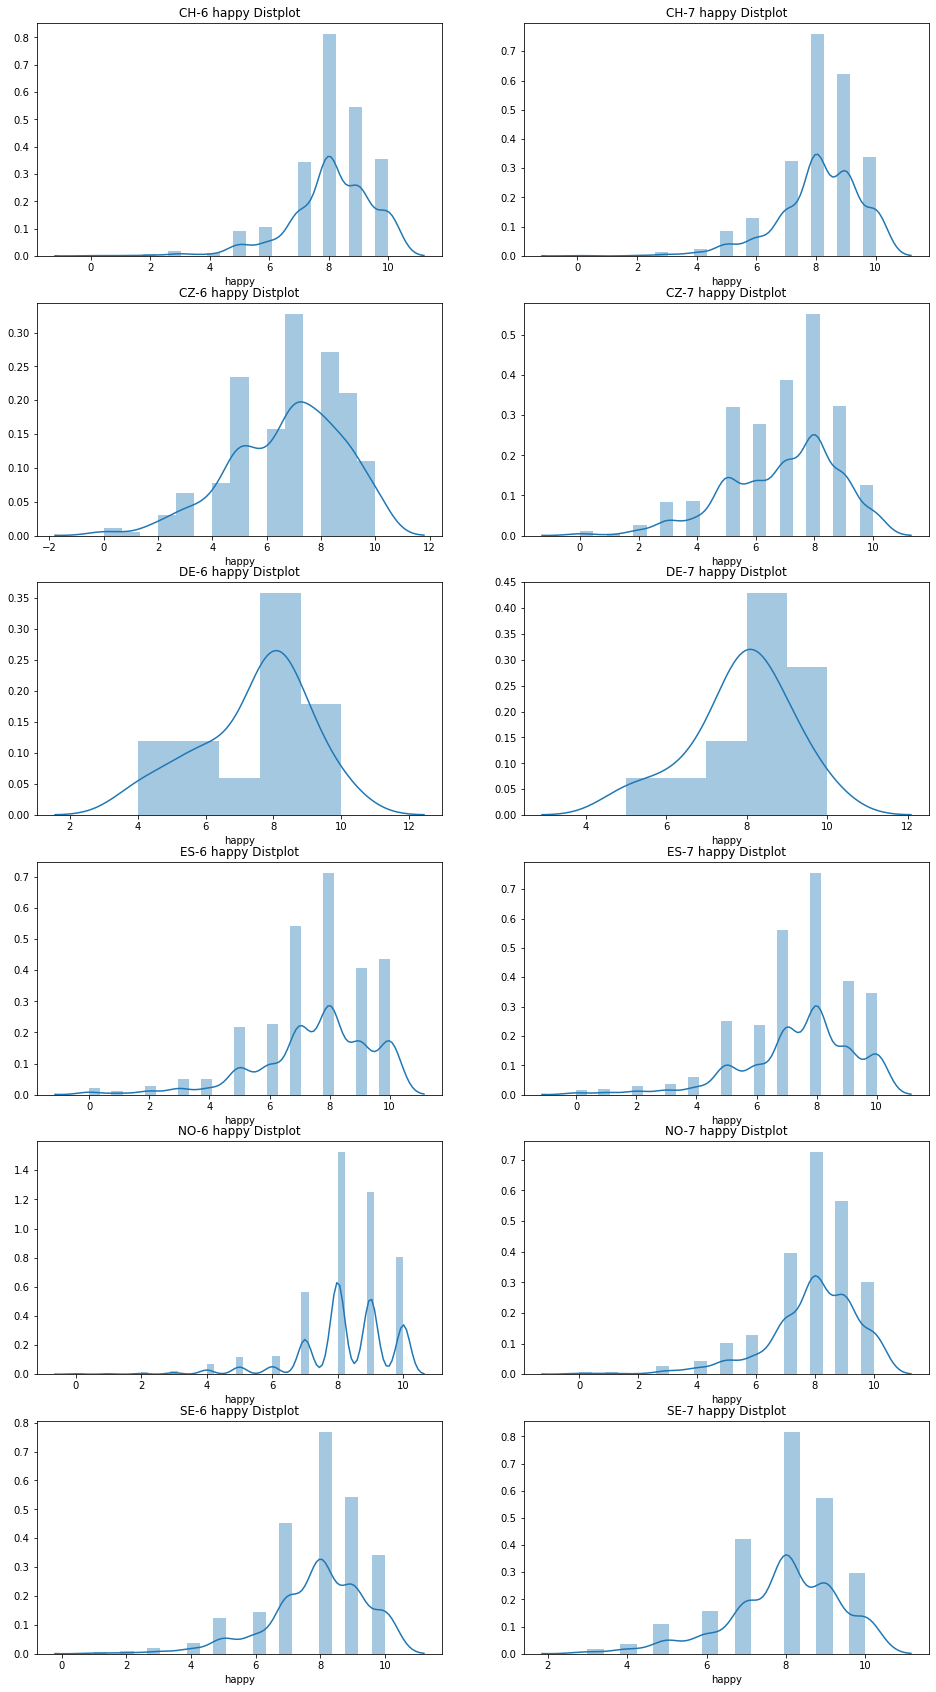

In [187]:
make_sns_distplots(happy_dfs, 'happy')

Interestingly, the general mean of happiness is adjusted further to the right in this case, meaning happiness appears to remain relatively higher than trust.

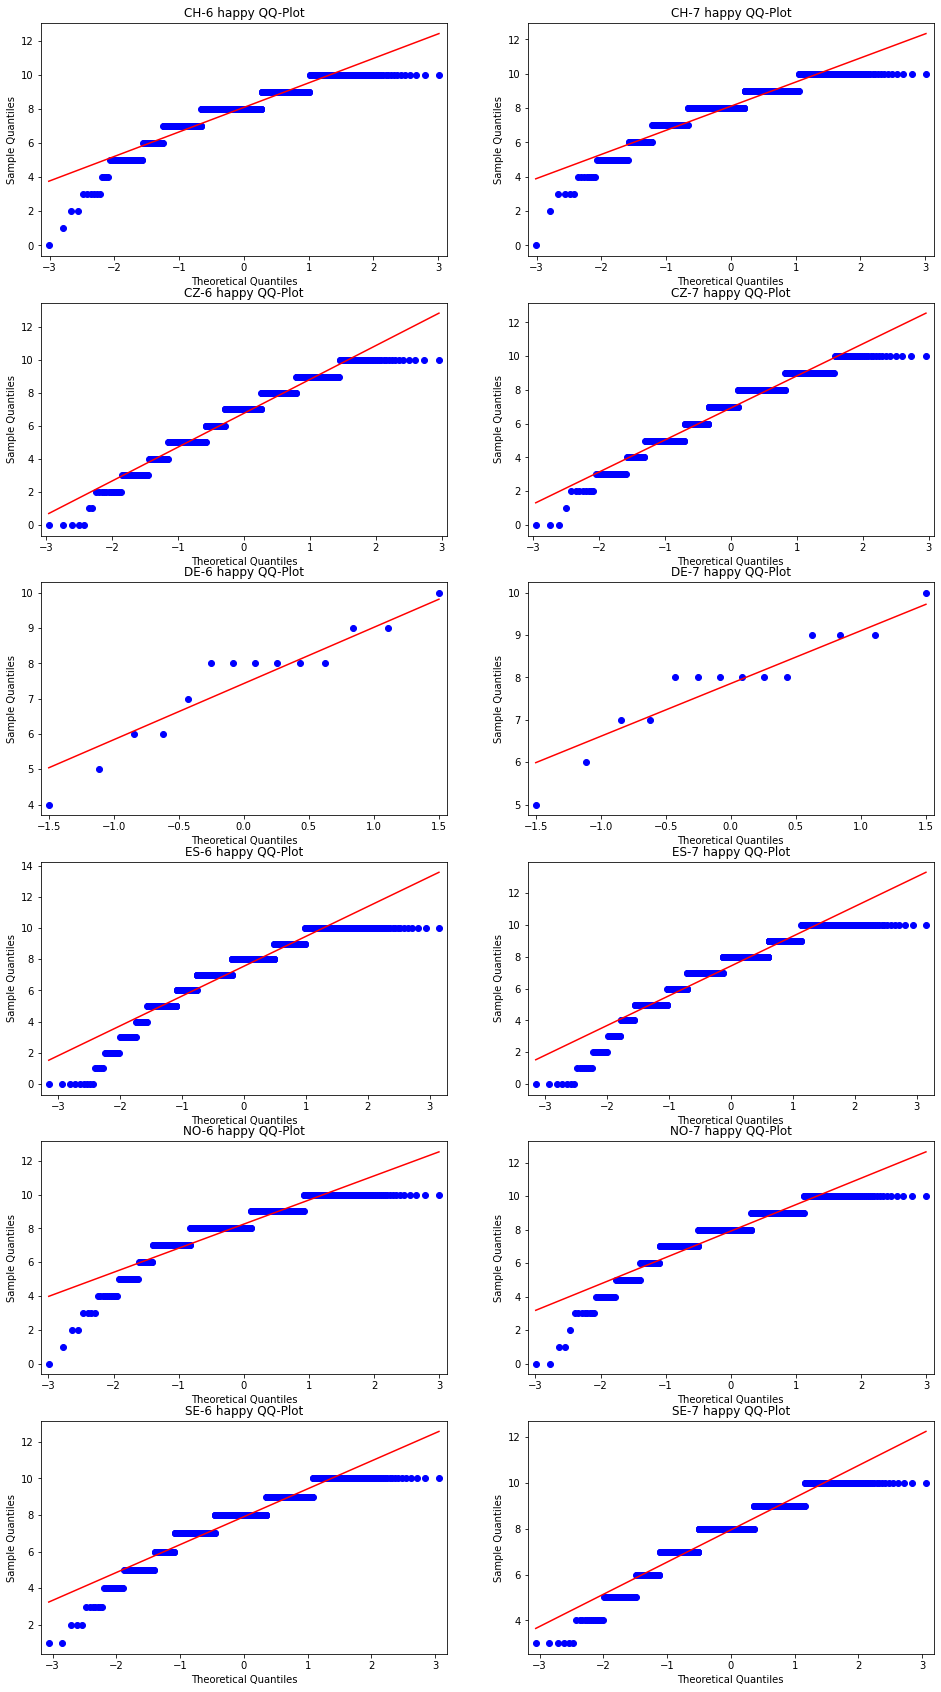

In [188]:
make_qq_plots(happy_dfs, 'happy')

Yeah, these are looking to be much less normal than the trustworthiness variable.

In [190]:
statistical_norm_tests(happy_dfs, 'happy')

('CH', 6) happy:
Shapiro-Wilk: (0.8790070414543152, 5.283100089878269e-24)
NormaltestResult(statistic=188.44583258657116, pvalue=1.2009014936632828e-41)
('CH', 7) happy:
Shapiro-Wilk: (0.8898855447769165, 5.33521397677116e-23)
NormaltestResult(statistic=155.7517081053111, pvalue=1.509893485812781e-34)
('CZ', 6) happy:
Shapiro-Wilk: (0.9487239122390747, 4.237028886381819e-14)
NormaltestResult(statistic=33.01518783857956, pvalue=6.773966606071022e-08)
('CZ', 7) happy:
Shapiro-Wilk: (0.941163182258606, 3.1696701334590557e-15)
NormaltestResult(statistic=41.0748376864304, pvalue=1.2042379903191192e-09)
('DE', 6) happy:
Shapiro-Wilk: (0.916941225528717, 0.1986599564552307)
NormaltestResult(statistic=1.506462655423323, pvalue=0.4708426450576315)
('DE', 7) happy:
Shapiro-Wilk: (0.9213663339614868, 0.23006466031074524)
NormaltestResult(statistic=2.1782905366822414, pvalue=0.33650399143734494)
('ES', 6) happy:
Shapiro-Wilk: (0.9025752544403076, 4.448357370406131e-27)
NormaltestResult(statistic=2

Again, the only one where it isn't sure is DE (Germany), and this is because of the very low number of samples for this country. Definitely looks like another case where Wilcoxon makes the most sense for significance testing.

In [191]:
for country in data.cntry.unique():
    x = happy_dfs[country, 7].sort_values('idno').happy
    y = happy_dfs[country, 6].sort_values('idno').happy
    print(country, wilcoxon(x, y, alternative='greater'))

CH WilcoxonResult(statistic=92928.5, pvalue=0.494758607632381)
CZ WilcoxonResult(statistic=83307.0, pvalue=0.09159675907669274)
DE WilcoxonResult(statistic=42.5, pvalue=0.196675658459254)
ES WilcoxonResult(statistic=231958.5, pvalue=0.9686865910870008)
NO WilcoxonResult(statistic=67571.5, pvalue=0.999995662978353)
SE WilcoxonResult(statistic=129774.0, pvalue=0.3463918056859801)


Alright, looks like no country really got happier from 2012 to 2014. Let's check the reverse.

In [192]:
for country in data.cntry.unique():
    x = happy_dfs[country, 7].sort_values('idno').happy
    y = happy_dfs[country, 6].sort_values('idno').happy
    print(country, wilcoxon(x, y, alternative='less'))

CH WilcoxonResult(statistic=92928.5, pvalue=0.505241392367619)
CZ WilcoxonResult(statistic=83307.0, pvalue=0.9084032409233073)
DE WilcoxonResult(statistic=42.5, pvalue=0.8033243415407461)
ES WilcoxonResult(statistic=231958.5, pvalue=0.031313408912999205)
NO WilcoxonResult(statistic=67571.5, pvalue=4.337021647005372e-06)
SE WilcoxonResult(statistic=129774.0, pvalue=0.65360819431402)


On the other hand, it does appear that Spain and Norway both dropped in their happiness levels! Other than that, they appear to remain consistent in the other countries.

In [194]:
data.groupby(['cntry', 'year']).agg('mean')

idno     tvtot   ppltrst   pplfair    pplhlp     happy  \
cntry year                                                                   
CH    6     1.480680e+03  3.141192  5.677878  6.350649  5.726329  8.088312   
      7     1.480680e+03  3.065977  5.751617  6.219922  5.671410  8.116429   
CZ    6     1.445666e+03  5.142420  4.362519  4.959938  4.503058  6.770898   
      7     1.445666e+03  4.686930  4.424658  4.904255  4.465753  6.914110   
DE    6     1.100048e+07  4.928571  5.214286  5.692308  5.000000  7.428571   
      7     1.100048e+07  3.071429  5.357143  6.714286  5.857143  7.857143   
ES    6     1.467607e+03  3.977741  5.114592  5.354253  4.748344  7.548680   
      7     1.467607e+03  4.015677  4.895128  5.340284  4.326716  7.419967   
NO    6     1.430671e+04  3.837209  6.649315  6.927298  6.085048  8.251719   
      7     1.430671e+04  3.705882  6.598630  6.861454  6.001374  7.915185   
SE    6     1.765173e+03  3.691630  6.058499  6.559116  6.039691  7.907387   
      7     1.765173e+03  3.585447  6.257709  6.836464  6.082781  7.946961   

             sclmeet    sclact      gndr       agea   partner  
cntry year                                                     
CH    6     5.080519  2.704724  1.514877  47.344415  1.349288  
      7     5.160622  2.781699  1.512290  46.141145  1.376455  
CZ    6     4.648855  2.613354  1.515198  47.053208  1.432927  
      7     4.445802  2.703077  1.535494  45.552262  1.420245  
DE    6     5.000000  2.857143  1.571429  52.071429  1.357143  
      7     4.428571  2.714286  1.571429  59.714286  1.142857  
ES    6     5.228737  2.560266  1.515251  47.700340  1.372727  
      7     5.260116  2.616878  1.493817  48.048223  1.398347  
NO    6     5.530780  2.965565  1.471956  46.364903  1.348422  
      7     5.302326  2.859097  1.461012  46.707521  1.390411  
SE    6     5.528115  2.917960  1.471366  48.673563  1.387665  
      7     5.426211  2.879425  1.482379  49.403189  1.386564

## 3. Who reported watching more TV in 2012, men or women?

In [196]:
men = data[(data.year == 6) & (data.gndr == 1)].copy()
women = data[(data.year == 6) & (data.gndr == 2)].copy()

In [213]:
men = men[~men.tvtot.isna()]
women = women[~women.tvtot.isna()]

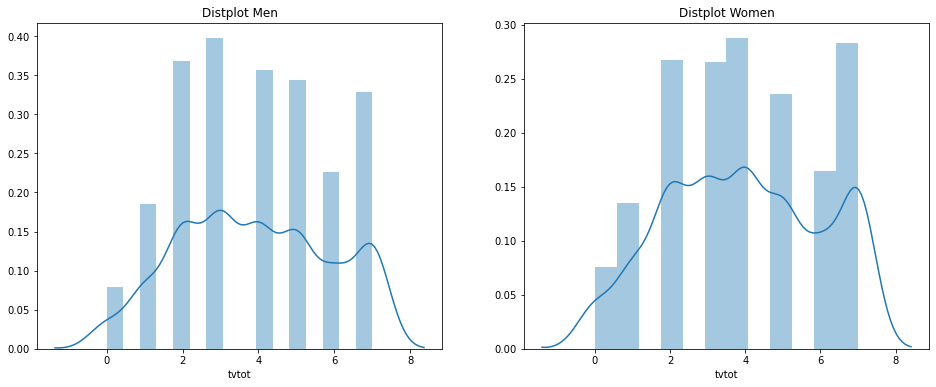

In [214]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.distplot(men.tvtot)
plt.title('Distplot Men')
plt.subplot(122)
sns.distplot(women.tvtot)
plt.title('Distplot Women')
plt.show()

These distributions look extremely similar and the disparity in the number of men and women respondents is only about 10, so the class is quite balanced, it definitely doesn't look like these two are normal! Non-parametric test should be used here as well. These two groups should be independent of one another as gender in this case is an independent variable. So the tests to compare the two that make the most sense are: Mann-Whitney U, Mood's Median Test, and Kruskal-Wallis Test. We'll do all three.

In [229]:
print(mannwhitneyu(men.tvtot, women.tvtot))
print(f"Mood's Median: {median_test(men.tvtot, women.tvtot)[0:2]}")
print(kruskal(men.tvtot, women.tvtot))

MannwhitneyuResult(statistic=2271081.5, pvalue=0.22382598497660156)
Mood's Median: (0.10448797978115422, 0.7465089423999145)
KruskalResult(statistic=0.5766091020549451, pvalue=0.447644522500795)


As predicted, the differences between males and females in their TV watching in 2012 don't appear to be significantly different.

## 4. Who was more likely to believe people were fair in 2012, people living with a partner or people living alone?

Similar to the prior question, just in a different context. Let's split the data up.

In [224]:
has_partner = data[(data.partner == 1) & (data.year == 6)]
no_partner = data[(data.partner == 2) & (data.year == 6)]
has_partner = has_partner[~has_partner.pplfair.isna()]
no_partner = no_partner[~no_partner.pplfair.isna()]

In [225]:
has_partner.shape[0], no_partner.shape[0]

(2663, 1608)

Looks like the number of people with partners is a decent amount greater than those without, we should keep that in mind.

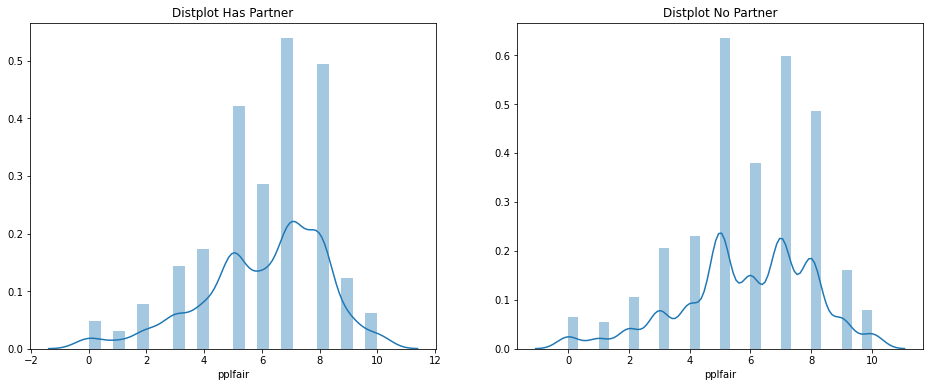

In [226]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.distplot(has_partner.pplfair)
plt.title('Distplot Has Partner')
plt.subplot(122)
sns.distplot(no_partner.pplfair)
plt.title('Distplot No Partner')
plt.show()

This may be worth looking into to see if it's close to normal. But we can see there is a chance, even though the distributions are similar that, there are more people with partners that rate higher in the 8 range than no partner group.

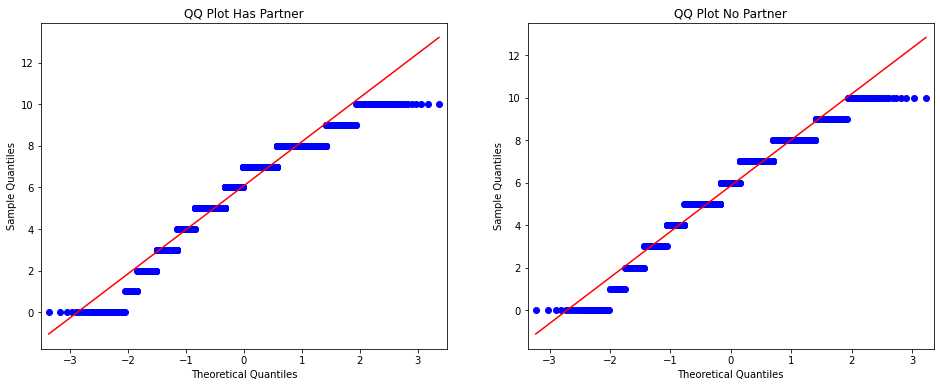

In [230]:
plt.figure(figsize=(16,6))
ax = plt.subplot(121)
fig = qqplot(has_partner.pplfair, line='s', ax=ax)
plt.title('QQ Plot Has Partner')
ax = plt.subplot(122)
fig = qqplot(no_partner.pplfair, line='s', ax=ax)
plt.title('QQ Plot No Partner')
plt.show()

Pretty positive these aren't going to pop up as normal in any of the normality tests.

In [232]:
print(f'Has Partner Shapiro: {shapiro(c)}')
print(f'Has Partner {normaltest(has_partner.pplfair)}')
print(f'No Partner Shapiro: {shapiro(no_partner.pplfair)}')
print(f'No Partner {normaltest(no_partner.pplfair)}')

Has Partner Shapiro: (0.9410251975059509, 2.4778057341886867e-31)
Has Partner NormaltestResult(statistic=179.10400993848867, pvalue=1.2825030260118621e-39)
No Partner Shapiro: (0.9561690092086792, 1.4302870646482291e-21)
No Partner NormaltestResult(statistic=64.92830332216809, pvalue=7.961558194894824e-15)


As presumed, these are all coming up non-normal. So once again the same tests used in the prior question will be used here again, assuming the two groups are independent of one another (which I believe is unlikely).

In [233]:
print(mannwhitneyu(has_partner.pplfair, no_partner.pplfair))
print(f"Mood's Median: {median_test(has_partner.pplfair, no_partner.pplfair)[0:2]}")
print(kruskal(has_partner.pplfair, no_partner.pplfair))

MannwhitneyuResult(statistic=1998233.5, pvalue=0.00010499272215466025)
Mood's Median: (17.308749957810758, 3.177204901948618e-05)
KruskalResult(statistic=13.739649374653519, pvalue=0.00020997468964373384)


In this case there appears to be a significant difference using all three tests, this would indicate that one group does have a difference in opinion than the other in whether people are fair or not.

In [236]:
print(mannwhitneyu(has_partner.pplfair, no_partner.pplfair, alternative='greater'))
print(f"Mood's Median: {median_test(has_partner.pplfair, no_partner.pplfair, ties='above')[0:2]}")

MannwhitneyuResult(statistic=2283870.5, pvalue=0.00010499272215466025)
Mood's Median: (14.516128757679908, 0.00013896467044780322)


It would appear that we can reject the hypothesis that those with partners have lower responses in terms of fairness than those without partners. This seems intuitive and makes sense.

## 5. Pick three or four of the countries in the sample and compare how often people met socially in 2014. Are there differences, and if so, which countries stand out?

We won't use DE (Germany) since the number of samples are so low. Then I'll just choose 4 of them.

In [241]:
cntry_2014 = {}
for country in ['CH', 'ES', 'NO', 'SE']:
    temp = data[(data.cntry == country) & (data.year == 7)].copy()
    cntry_2014[country] = temp[~temp.sclmeet.isna()].copy()

Check out the distributions for each country.

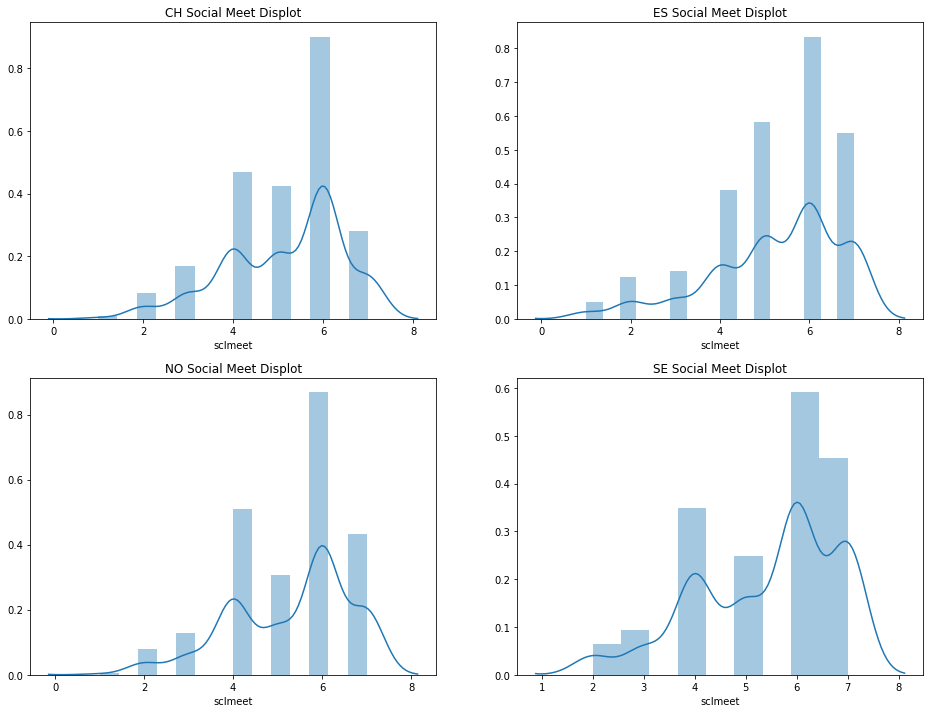

In [242]:
plt.figure(figsize=(16,12))
for i, key in enumerate(cntry_2014, 1):
    plt.subplot(2,2,i)
    sns.distplot(cntry_2014[key].sclmeet)
    plt.title(f'{key} Social Meet Displot')
plt.show()

I'm going to go out on a limb here and say these do not follow the normal distribution! So we'll once again use non-parametric tests to see if any of these are significantly different from one another. Relevant tests in this case will be Mood's median test and the Kruskal-Wallis H-test.

In [247]:
arrays = [cntry_2014[key].sclmeet for key in cntry_2014]
cntrys = [key for key in cntry_2014]

In [249]:
print(median_test(arrays[0], arrays[1], arrays[2], arrays[3]))
print(kruskal(arrays[0], arrays[1], arrays[2], arrays[3]))

(47.538785137215534, 2.6693863103109346e-10, 6.0, array([[ 93, 250, 136, 229],
       [679, 961, 595, 679]], dtype=int64))
KruskalResult(statistic=21.186241353532942, pvalue=9.630426325908598e-05)


So this is indicating that there is a difference between the samples here! But what's the difference and where?

In [258]:
combos = list(itertools.combinations([key for key in cntry_2014], r=2))

In [260]:
for a, b in combos:
    print(a, b)
    print(mannwhitneyu(cntry_2014[a].sclmeet, cntry_2014[b].sclmeet))
    print(f"Mood's Median: {median_test(cntry_2014[a].sclmeet, cntry_2014[b].sclmeet)[0:2]}")
    print(kruskal(cntry_2014[a].sclmeet, cntry_2014[b].sclmeet))

CH ES
MannwhitneyuResult(statistic=437259.5, pvalue=0.006174327378539008)
Mood's Median: (23.76324094923116, 1.0894331438731e-06)
KruskalResult(statistic=6.260317221619147, pvalue=0.012347209292747114)
CH NO
MannwhitneyuResult(statistic=262752.5, pvalue=0.00829942530647597)
Mood's Median: (12.000935572943376, 0.0005317384996644553)
KruskalResult(statistic=5.738595597411514, pvalue=0.016596057291419577)
CH SE
MannwhitneyuResult(statistic=305975.0, pvalue=1.7264168438450082e-06)
Mood's Median: (45.89133055448305, 1.249979056007004e-11)
KruskalResult(statistic=21.54736733163118, pvalue=3.451962279774607e-06)
ES NO
MannwhitneyuResult(statistic=441874.5, pvalue=0.47443309960851965)
Mood's Median: (1.0659064492755896, 0.30187191598669527)
KruskalResult(statistic=0.004118258500640619, pvalue=0.9488319512783521)
ES SE
MannwhitneyuResult(statistic=517268.0, pvalue=0.00818216038075548)
Mood's Median: (5.952530127496002, 0.014696178117458505)
KruskalResult(statistic=5.763475949315309, pvalue=0.01

It looks like the social meeting stats are pretty different between most the countries here with the exception of Spain and Norway.

## 6. Pick three or four of the countries in the sample and compare how often people took part in social activities, relative to others their age, in 2014. Are there differences, and if so, which countries stand out?

Basically the same question as the last, again with a different context.

In [261]:
cntry_2014 = {}
for country in ['CH', 'ES', 'NO', 'SE']:
    temp = data[(data.cntry == country) & (data.year == 7)].copy()
    cntry_2014[country] = temp[~temp.sclact.isna()].copy()

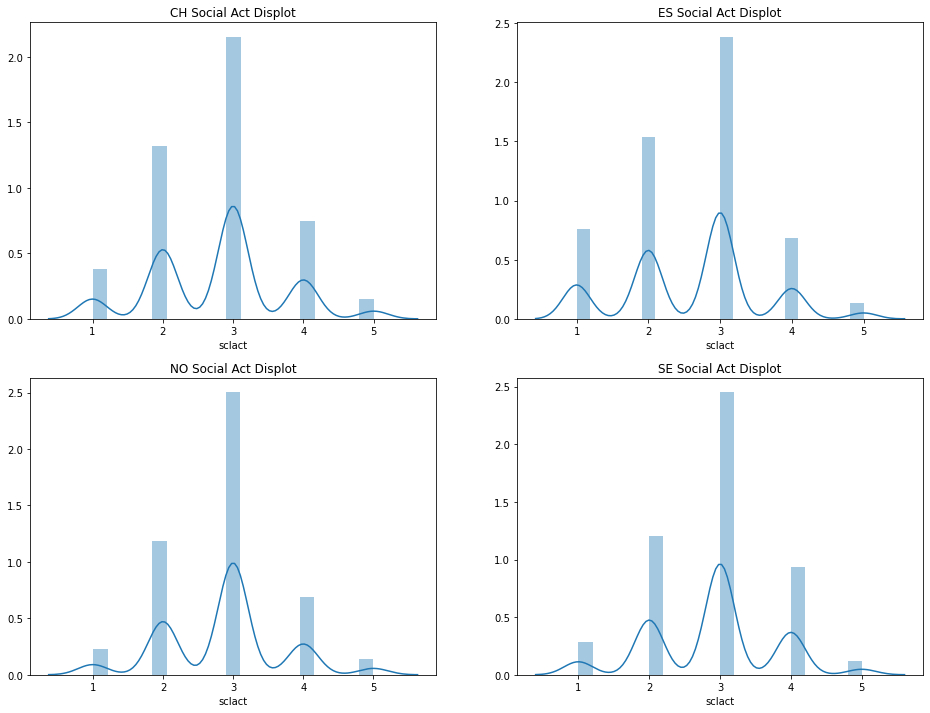

In [262]:
plt.figure(figsize=(16,12))
for i, key in enumerate(cntry_2014, 1):
    plt.subplot(2,2,i)
    sns.distplot(cntry_2014[key].sclact)
    plt.title(f'{key} Social Act Displot')
plt.show()

Easy to see this is definitely not normal, these have multiple peaks and valleys and the data is very categorical.

In [263]:
arrays = [cntry_2014[key].sclact for key in cntry_2014]
cntrys = [key for key in cntry_2014]

In [264]:
print(median_test(arrays[0], arrays[1], arrays[2], arrays[3]))
print(kruskal(arrays[0], arrays[1], arrays[2], arrays[3]))

(14.454049516082513, 0.0023479570591808485, 3.0, array([[ 144,  176,  128,  191],
       [ 621, 1009,  603,  713]], dtype=int64))
KruskalResult(statistic=51.435463080118915, pvalue=3.951049580135163e-11)


Once again, differences look significant somewhere in there.

In [265]:
combos = list(itertools.combinations([key for key in cntry_2014], r=2))

In [266]:
for a, b in combos:
    print(a, b)
    print(mannwhitneyu(cntry_2014[a].sclact, cntry_2014[b].sclact))
    print(f"Mood's Median: {median_test(cntry_2014[a].sclact, cntry_2014[b].sclact)[0:2]}")
    print(kruskal(cntry_2014[a].sclact, cntry_2014[b].sclact))

CH ES
MannwhitneyuResult(statistic=412403.5, pvalue=0.00017760126994167955)
Mood's Median: (5.059103111909514, 0.024496912318704232)
KruskalResult(statistic=12.754554833677119, pvalue=0.000355143264757474)
CH NO
MannwhitneyuResult(statistic=266455.5, pvalue=0.04481416411492448)
Mood's Median: (0.3495938254716172, 0.5543431457022483)
KruskalResult(statistic=2.8812552822458692, pvalue=0.08961613619249918)
CH SE
MannwhitneyuResult(statistic=323561.5, pvalue=0.007624761671771617)
Mood's Median: (1.2320789605885036, 0.2670031104099251)
KruskalResult(statistic=5.8876737400699675, pvalue=0.015247228760072416)
ES NO
MannwhitneyuResult(statistic=373050.5, pvalue=2.3543257190338604e-08)
Mood's Median: (2.1976998778726644, 0.13821684280652347)
KruskalResult(statistic=29.83367275340488, pvalue=4.707445342600102e-08)
ES SE
MannwhitneyuResult(statistic=453315.5, pvalue=6.852562437656029e-11)
Mood's Median: (13.517341299427338, 0.00023636905086892553)
KruskalResult(statistic=41.205788876860574, pvalu

In this case there is a bit more of a mix up, as certain tests claim significance and others do not. It appears that there is definitely a difference between CH and ES; ES and SE, but none of the others are very consistent.